In [4]:
import numpy as np
from numpy import sqrt, exp, array, arange
import matplotlib.pyplot as plt

from scipy.sparse import csc_matrix
from scipy.sparse.linalg import spsolve
from scipy.stats import norm
from scipy.interpolate import CubicSpline

import sympy
sympy.init_printing

def display_matrix(m):
    display(sympy.Matrix(m))

In [5]:
# utilities

def calculateError(arr1, arr2, p=2):
    """
    Calculate error using mean p-norm error
    Note: both arrays should be the same shape
    """
    assert len(arr1) == len(arr2)

    return (1 / len(arr1)) * np.sum(np.abs(arr1 - arr2) ** p)


# inverse transform sampling

In [6]:
# Black-Scholes analytical pricing formula for european options
def blackScholesPricer(S, K, r, sigma, T, type="call"):
    """
    S       : stock price
    K       : strike price
    r       : risk-free interest rate
    sigma   : volatility
    T       : time to expiry
    """

    assert type in ["call", "put"]

    d_1 = (np.log(S / K) + (r + sigma ** 2 / 2) * T) / (sigma * np.sqrt(T))
    d_2 = (np.log(S / K) + (r - sigma ** 2 / 2) * T) / (sigma * np.sqrt(T))

    if type == "call":
        option_price = S * norm.cdf(d_1) - K * exp(-r * T) * norm.cdf(d_2)
    elif type == "put":
        option_price = K * exp(-r * T) * norm.cdf(-d_2) - S * norm.cdf(-d_1)

    return option_price

In [7]:
# Cox-Ross-Rubinstein (CRR) Binomial tree pricer
def binomialPricer(S, K, r, sigma, T, q, n, type="call", style="european", visualize=False):
    """
    S       : initial stock price
    K       : strike price
    r       : risk-free interest rate
    sigma   : volatility
    T       : time to expiry
    q       : continuous dividend yield
    n       : size of tree
    """

    assert type in ["call", "put"]
    assert style in ["american", "european"]

    # Useful quantities to define
    t = T / n
    u = exp(sigma * sqrt(t))
    d = exp(-sigma * sqrt(t))
    a = exp((r-q) * t)
    p = (a - d) / (u - d)

    price_tree = []
    for i in range(0, n+1):
        node_list = np.zeros((i+1,2)) # left to right encodes lowest to highest
        for j in range(0, i+1):
            # each node is [stock price, option price]: option price is zero-initialized
            node_list[j, 0] = S * (u ** j) * (d ** (i-j))
        price_tree.append(node_list)

    # calculate option prices at expiration date
    for j in range(0, n+1):
        S_nj = price_tree[-1][j, 0]

        if type == "call":
            price_tree[-1][j, 1] = max(S_nj - K, 0)
        elif type == "put":
            price_tree[-1][j, 1] = max(K - S_nj, 0) 

    # update option prices but moving backwards through the tree
    for i in range(n-1, -1, -1):
        for j in range(0, i+1):

            # discounted expected value
            binomial_price = exp(-r * t) * (p * price_tree[i+1][j+1, 1] + (1-p) * price_tree[i+1][j, 1])

            S_ij = price_tree[i][j, 0]
            if type == "call":
                exercise_price = max(S_ij - K, 0)
            elif type == "put":
                exercise_price = max(K - S_ij, 0) 
            
            if style == "american":
                price_tree[i][j, 1] = max(binomial_price, exercise_price)
            elif style == "european":
                price_tree[i][j, 1] = binomial_price

    if visualize:
        for i in range(0, n+1):
            print(price_tree[i])

    return price_tree[0][0, 1]


In [8]:
# use Monte Carlo methods for pricing the option

def monteCarloPricer(S_0, K, r, sigma, q, T, N, num_trials, style="european", type="put", method="default"):

    # sample a path for S(t) in a risk neutral world
    # calculate the payoff from the derivative
    # repeat steps 1 and 2
    # calculate the mean of sample payoffs to get estimate of the expected payoff
    # discount expected payoff at the risk free rate

    assert type in ["call", "put"]
    assert style in ["european", "american"]
    assert method in ["default", "antithetic", "importance"]

    deltaT = T / N
    deltaT_sqrt = np.sqrt(T/N)
    T_sqrt = np.sqrt(T)

    # pricing func
    pricing_func = lambda eps: S_0 * exp((r - sigma ** 2 / 2) * T + sigma * T_sqrt * eps)

    # volatility and interest rates are constant
    rng = np.random.default_rng(300)
    variates = rng.standard_normal(num_trials)

    if type == "put":

        if method == "default":
            sampled_payoffs = np.maximum(K - pricing_func(variates), 0)

        elif method == "antithetic":
            f1 = np.maximum(K - pricing_func(variates), 0)
            f2 = np.maximum(K - pricing_func(-variates), 0)
            sampled_payoffs = (f1 + f2) / 2

    elif type == "call":

        if method == "default":
            sampled_payoffs = np.maximum(pricing_func(variates) - K, 0)

        elif method == "antithetic":
            f1 = np.maximum(pricing_func(variates) - K, 0)
            f2 = np.maximum(pricing_func(-variates) - K, 0)
            sampled_payoffs = (f1 + f2) / 2

    return exp(-r*T) * np.mean(sampled_payoffs), np.std(exp(-r*T) * sampled_payoffs)


# params for testing
initial_S = 100
strike = 95
interest_rate = 0.01
maturity = 0.25
volatility = 0.50
dividend_rate = 0

bsm_price = blackScholesPricer(S=initial_S, K=strike, r=interest_rate, sigma=volatility, T=maturity, type="put")

default_prices = []
default_errors = []
antithetic_prices = []
antithetic_errors = []
for num_trials in 10 ** arange(3, 9):
    option_price, omega = monteCarloPricer(S_0=initial_S, K=strike, r=interest_rate, sigma=volatility, q=0, T=maturity,
                                       N=1000, num_trials=num_trials, type="put", method="default")
    option_price_a, omega_a = monteCarloPricer(S_0=initial_S, K=strike, r=interest_rate, sigma=volatility, q=0, T=maturity,
                                       N=1000, num_trials=num_trials, type="put", method="antithetic")
    default_prices.append(option_price)
    default_errors.append(1.96 * omega / sqrt(num_trials))
    antithetic_prices.append(option_price_a)
    antithetic_errors.append(1.96 * omega_a / sqrt(num_trials))

print("The option price is:", option_price)
print("The Black-Scholes-Merton price is:", bsm_price)
print("The standard deviation of payoffs is:", omega)
print("A 95 percent confidence interval for the option price is:", [option_price - 1.96 * omega / np.sqrt(num_trials), option_price + 1.96 * omega / np.sqrt(num_trials)])

The option price is: 7.29036923361702
The Black-Scholes-Merton price is: 7.290720020280162
The standard deviation of payoffs is: 10.751307464397307
A 95 percent confidence interval for the option price is: [7.288261977353998, 7.292476489880042]


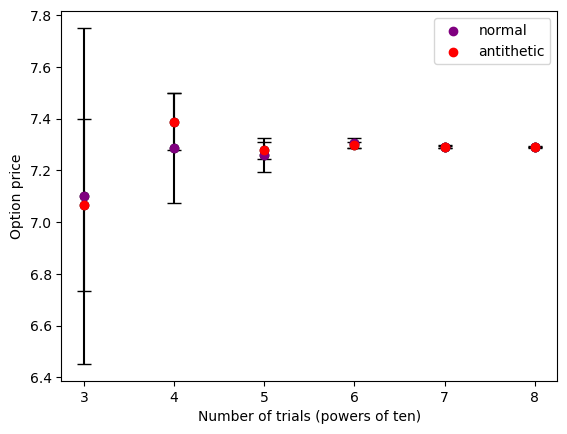

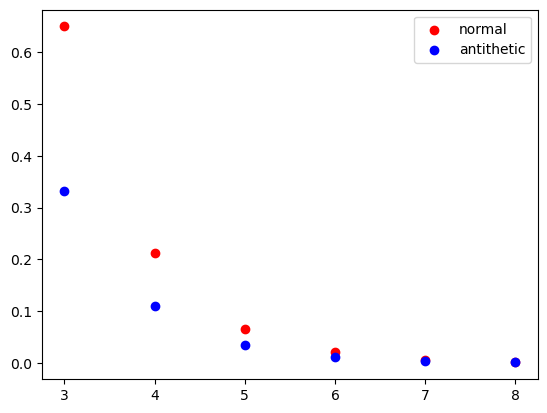

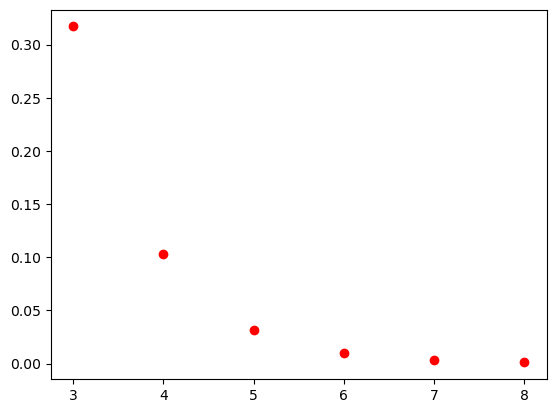

<Figure size 640x480 with 0 Axes>

In [22]:
plt.scatter(arange(3, 9), default_prices, color="purple", zorder=2, label="normal")
plt.errorbar(arange(3, 9), default_prices, yerr=default_errors, fmt='o', color='black', zorder=1, capsize=5)
plt.scatter(arange(3, 9), antithetic_prices, color="red", zorder=2, label="antithetic")
plt.errorbar(arange(3, 9), antithetic_prices, yerr=antithetic_errors, fmt='o', color='black', zorder=1, capsize=5)
plt.xlabel("Number of trials (powers of ten)")
plt.ylabel("Option price")
plt.legend()
plt.show()
plt.clf()

plt.scatter(arange(3, 9), default_errors, color="red", label="normal")
plt.scatter(arange(3, 9), antithetic_errors, color="blue", label="antithetic")
plt.legend()
plt.show()
plt.clf()

plt.scatter(arange(3, 9), np.array(default_errors) / np.array(antithetic_errors), color="red")
plt.show()
plt.clf()

In [10]:
# use finite differences to solve the Black-Scholes PDE to obtain option price

def finiteDifferencesPricer(K, r, sigma, q, S_max, M, T, N, type="call", style="european"):
    """
    K : strike price
    r : risk-free interest rate
    sigma : volatility
    S_max: maximum stock price
    T : total time until maturity (in years)
    q : continuous dividend yield
    N : number of grid-points in time
    M : number of grid-points in stock price
    """

    assert style in ["european", "american"]
    assert type in ["call", "put"]

    deltaT = T / N
    deltaS = S_max / M

    # stock price increases from top-to-bottom: 0, deltaS, 2 * deltaS, ..., (M-1) * deltaS, S_max
    # time increases from left-to-right: 0, deltaT, 2 * deltaT, ..., (N-1) * deltaT, T
    grid = np.zeros((N+1, M+1)) # grid is (N + 1) x (M + 1): time on vertical, stock price on horizontal

    # helper arrays
    t_arr = arange(0, N+1) * deltaT
    S_arr = arange(0, M+1) * deltaS

    # boundary conditions on domain: [0, T] x [0, S_max]
    if style == "european":

        if type == "put":
            zero_S_bc = K * exp(-r * (T - t_arr))
            large_S_bc = 0 # the no-arbitrage bound is p >= max(Ke^{-rT}-S_0, 0), but we choose S_max large enough
            maturity_bc = np.maximum(K - S_arr, 0)

        elif type == "call":
            zero_S_bc = 0
            large_S_bc = S_max - K * exp(-r * (T - t_arr))
            maturity_bc = np.maximum(S_arr - K, 0)

    elif style == "american":

        if type == "put":
            zero_S_bc = K
            large_S_bc = 0
            maturity_bc = np.maximum(K - S_arr, 0)
            
        elif type == "call":
            zero_S_bc = 0
            large_S_bc = S_max - K
            maturity_bc = np.maximum(S_arr - K, 0)

    # apply boundary conditions to grid
    grid[:, -1] = large_S_bc
    grid[:, 0] = zero_S_bc
    grid[-1, :] = maturity_bc

    # display_matrix(grid)

    # coefficients
    a_vec = 0.5 * (r - q) * arange(1, M) * deltaT - 0.5 * (sigma ** 2) * (arange(1, M) ** 2) * deltaT
    b_vec = 1 + r * deltaT + (sigma ** 2) * (arange(1, M) ** 2) * deltaT
    c_vec = -0.5 * (r - q) * arange(1, M) * deltaT - 0.5 * (sigma ** 2) * (arange(1, M) ** 2) * deltaT

    # need to solve a sparse linear system for each iteration
    tri = csc_matrix(np.diag(a_vec[1:], k=-1) + np.diag(b_vec, k=0) + np.diag(c_vec[:-1], k=1))

    # backwards iteration
    for i in range(N-1, -1, -1):

        # offset due to boundary conditions
        offset = np.zeros(M-1)
        offset[0] = a_vec[0] * grid[i, 0]
        offset[-1] = c_vec[-1] * grid[i, M]
        
        forward = grid[i+1, 1:M]

        prices_at_iteration = spsolve(tri, forward - offset)

        if style == "european":
            pass

        elif style == "american":
            if type == "put":
                prices_at_iteration = np.maximum(prices_at_iteration, K - arange(1, M) * deltaS)
            elif type == "call":
                prices_at_iteration = np.maximum(prices_at_iteration, arange(1, M) * deltaS - K)

        grid[i, 1:M] = prices_at_iteration

    # grid = np.matrix.round(grid, decimals=2); display_matrix(grid)
    # plt.plot(np.arange(0, S_max + deltaS, deltaS), grid[:, 0])
    # plt.plot(np.arange(0, S_max + deltaS, deltaS), np.arange(0, S_max + deltaS, deltaS) - K * exp(-r * T))

    return arange(0, M+1) * deltaS, grid[0, :]

(0.0, 290.32463415437854)

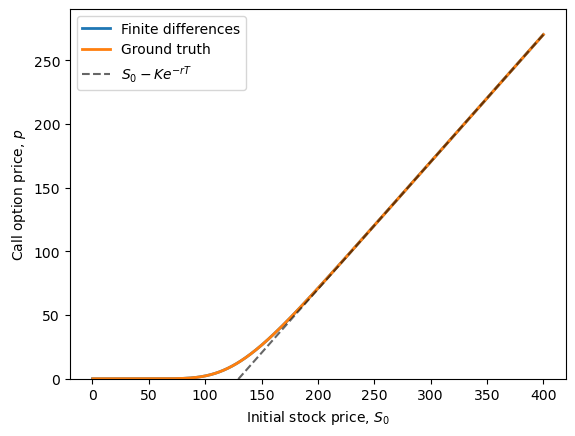

In [11]:
strike = 130
interest_rate = 0.01
maturity = 0.25
volatility = 0.50
dividend_rate = 0
max_stock_price = 400

s, sol = finiteDifferencesPricer(K=strike, r=interest_rate, sigma=volatility, q=dividend_rate,
                                S_max=max_stock_price, M=1500, T=maturity, N=1000,
                                type="call", style="european")

# true solution comes Black-Scholes-Merton formula
true_sol = blackScholesPricer(s[1:], K=strike, r=interest_rate, sigma=volatility, T=maturity, type="call")

plt.xlabel(r"Initial stock price, $S_0$")
plt.ylabel(r"Call option price, $p$")

plt.plot(s, sol, linewidth=2, label="Finite differences")
plt.plot(s[1:], true_sol, linewidth=2, label="Ground truth")
plt.plot(s, s - strike * exp(-interest_rate * maturity),
        linestyle="--", alpha=0.6, color="black", label=r"$S_0-Ke^{-rT}$")
plt.legend()
plt.ylim(bottom=0)

The mean 1-norm error is: 0.00020309464632620573
The theoretical price from Black-Scholes-Merton at initial stock price S = 100 is: 7.290720020280162
The price using finite differences is: 7.289538344015511


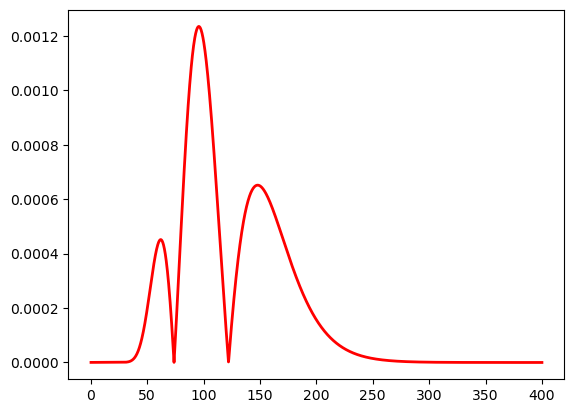

In [12]:
strike = 95
interest_rate = 0.01
maturity = 0.25
volatility = 0.50

s, european_sol = finiteDifferencesPricer(K=strike, r=interest_rate, sigma=volatility, q=0,
                                           S_max=400, M=1500, T=maturity, N=1000,
                                           type="put", style="european")

true_sol = blackScholesPricer(s[1:], K=strike, r=interest_rate, sigma=volatility, T=maturity, type="put")

plt.plot(s[1:], np.abs(european_sol[1:] - true_sol), linewidth=2, color="red")

err = calculateError(true_sol, european_sol[1:], p=1)

print("The mean 1-norm error is:", err)

initial_S = 100
bsm_price = blackScholesPricer(S=initial_S, K=strike, r=interest_rate, sigma=volatility, T=maturity, type="put")
cs = CubicSpline(s, european_sol)
fd_price = cs(initial_S)

print(f"The theoretical price from Black-Scholes-Merton at initial stock price S = {initial_S} is:", bsm_price)
print(f"The price using finite differences is:", fd_price)


In [13]:
# check that it agrees with example 21.1 in Options, Futures, and other Derivatives by John Hull
print("The price of the 5-month American put is:", binomialPricer(S=50, K=50, r=0.10, sigma=0.40, T=0.4167, q=0,
                                                                  n=30, type="put", style="american"))

option_prices = []
for N in [30, 50, 100, 500]:
    p = binomialPricer(S=50, K=50, r=0.10, sigma=0.40, T=0.4167, q=0,
                       n=N, type="put", style="american")
    option_prices.append(np.around(p, 3))
print(f"The prices found should be {option_prices} == [4.264, 4.272, 4.278, 4.283] to agree with Hull.")

print("The price of a 5-month American call is:", binomialPricer(S=50, K=50, r=0.10, sigma=0.40, T=0.4167, q=0, 
                                                                 n=300, type="call", style="european"))

# check that the pricing of European options obeys put-call parity (approximately?)
p = binomialPricer(S=50, K=50, r=0.10, sigma=0.40, T=0.4167, q=0, n=300, type="put", style="european")
c = binomialPricer(S=50, K=50, r=0.10, sigma=0.40, T=0.4167, q=0, n=300, type="call", style="european")
print("The price of the 5-month European put is:", p)
print("The price of the 5-month European call is:", c)
print("LHS of put-call parity:", c + 50 * exp(-0.10 * 0.4167))
print("RHS of put-call parity:", p + 50)

# check the lower bound on the price of a call option: c >= S - Ke^{-rT}
# by making S >> K (so that it is almost certainly exercised)
c = binomialPricer(S=1000, K=50, r=0.10, sigma=0.40, T=0.4167, q=0, n=300, type="call", style="european")
print("The price of the 5-month European call is:", c)
print("The lower bound on a European call is:", 1000 - 50 * exp(-0.10 * 0.4167))

The price of the 5-month American put is: 4.26356525884711
The prices found should be [4.264, 4.272, 4.278, 4.283] == [4.264, 4.272, 4.278, 4.283] to agree with Hull.
The price of a 5-month American call is: 6.1125445804183824
The price of the 5-month European put is: 4.0718575712322105
The price of the 5-month European call is: 6.1125445804183824
LHS of put-call parity: 54.071857571232215
RHS of put-call parity: 54.07185757123221
The price of the 5-month European call is: 952.0406870091853
The lower bound on a European call is: 952.0406870091862


In [14]:
# compare the binomial and black-scholes pricer

bsm_price = blackScholesPricer(S=100, K=95, r=0.01, sigma=0.50, T=0.25, type="put")
bin_price = binomialPricer(S=100, K=95, r=0.01, sigma=0.50, T=0.25, q=0,
                           n=2000, type="put", style="european")

print("The Black-Scholes-Merton price is:", bsm_price)
print("The binomial tree price is:", bin_price)


The Black-Scholes-Merton price is: 7.290720020280162
The binomial tree price is: 7.2918042535525585


In [15]:
s, sol = finiteDifferencesPricer(K=95, r=0.01, sigma=0.50, S_max=400, M=1500, q=0, T=0.25, N=1000, style="european", type="put")
cs = CubicSpline(s, sol)
print("The finite differences price is:", cs(100))

The finite differences price is: 7.289538344015511


[1.06434998e+02 1.06170480e+02 1.05903794e+02 ... 2.20391614e-04
 1.10102668e-04 0.00000000e+00]
[1.30000000e+02 1.29733333e+02 1.29466667e+02 ... 2.39421938e-04
 1.19609751e-04 0.00000000e+00]


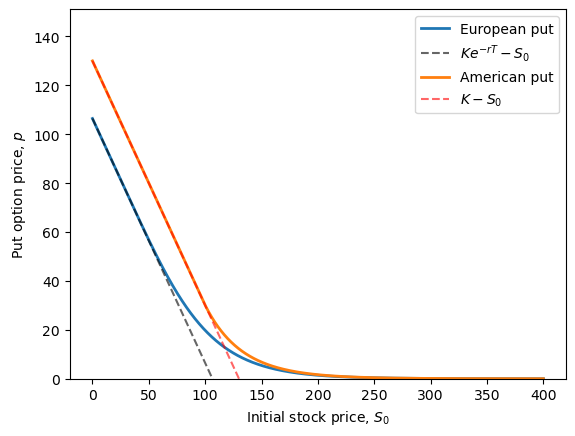

In [16]:
# compare american vs european-style puts using finite differences pricer

strike = 130
interest_rate = 0.2
maturity = 1.00

s1, european_sol = finiteDifferencesPricer(K=strike, r=interest_rate, sigma=0.40, q=0,
                                           S_max=400, M=1500, T=maturity, N=1000,
                                           type="put", style="european")
s2, american_sol = finiteDifferencesPricer(K=strike, r=interest_rate, sigma=0.40, q=0,
                                           S_max=400, M=1500, T=maturity, N=1000, 
                                           type="put", style="american")

print(european_sol)
print(american_sol)

plt.xlabel(r"Initial stock price, $S_0$")
plt.ylabel(r"Put option price, $p$")

plt.plot(s1, european_sol, linewidth=2, label="European put")
plt.plot(s1, strike * exp(-interest_rate * maturity) - s1, 
         linestyle="--", alpha=0.6, color="black", label=r"$Ke^{-rT}-S_0$")

plt.plot(s2, american_sol, linewidth=2, label="American put")
plt.plot(s2, strike - s2,
         linestyle="--", alpha=0.6, color="red", label=r"$K-S_0$")

# plt.xlim(left=0, right=0.5)
plt.ylim(bottom=0)
plt.legend()

In [17]:
option_prices = []
for N in range(2, 100):
    option_prices.append(binomialPricer(50, 50, 0.10, 0.40, 0.4167, 0, N, type="put", style="american"))

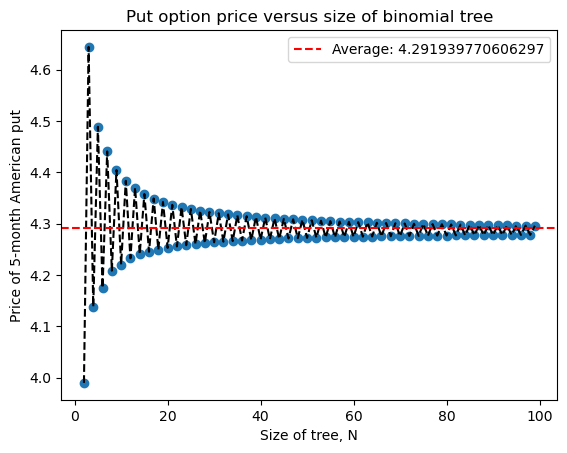

In [18]:
plt.scatter(range(2, 100), option_prices)
plt.plot(range(2, 100), option_prices, linestyle="--", color="black")
plt.xlabel("Size of tree, N")
plt.ylabel("Price of 5-month American put")
plt.axhline(np.average(option_prices), label=f"Average: {np.average(option_prices)}", color="red", linestyle="--")
plt.title("Put option price versus size of binomial tree")
plt.legend()